In [1]:
#-*- coding:utf8-*-
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns
sns.set(context="paper",font_scale=1.4)
colors = sns.color_palette()

import scipy as sp
import scipy.constants as const

import sympy as sym

import pandas as pd

import reportutils 
reportutils.set(ipynb_inline=True)

#from reportutils import Table

#import ROOT as rt

#import root_numpy as rnp

from aputils.latextables.tables import Table


# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"

In [2]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])

# Achsenskalierung
def axis_scale(factor, ax=None, axis="x"):
    if ax is None:
        ax = plt.gca()
    if axis == "x":
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    elif axis == "y":
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: x * factor))
    else:
        print("Wrong axis name given! Only x and y are allowed!")

def siunitx_ticklabels(ax=None, locale="DE", xaxis=True, yaxis=True,
                       round_precision=2, round_mode="places", scale_x=None, scale_y=None):
    """
    This function uses siunitx to create the ticklabels
    Main reason is for adjusting the decimal marker properly.
    The function takes 4 arguments:
        ax=None     the matplotlib axes to operate on
                    if set to None (Standard) this will be the current axes
        locale="DE" The locale parameter for siunitx, one of
                    "UK", "US", "DE", "FR" oder "ZA"
        xaxis=True  Boolean, if True the labels for the xaxis are set
        yaxis=True  Boolean, if True the labels for the yaxis are set
        round_precision=2 Number of places or figures after rounding
        round_mode="places" Rounds to round_precision many decimal places,
                  "figures" Rounds to round_precision many significant figures
                  
    """

    if ax is None:
        ax = plt.gca()

    if scale_x == None:
        scale_x = 1
    if scale_y == None:
        scale_y = 1
        
        
    if xaxis is True:
        xticks = ax.get_xticks()
        print(xticks)
        xlabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_x) for tick in xticks]
        #print(xlabels)
        ax.set_xticklabels(xlabels)

    if yaxis is True:
        yticks = ax.get_yticks()
        ylabels = [r"$\num[locale={},round-mode={},round-precision={}]{{{}}}$".format(
                   locale, round_mode,round_precision, tick*scale_y) for tick in yticks]
        #print(ylabels)
        ax.set_yticklabels(ylabels)    
        
        
def errorbar(x, y, ax=None, factor_x=1, factor_y=1, marker="o", linestyle="", **kwargs):
    if ax is None:
        ax = plt.gca()
    ax.errorbar(noms(x), noms(y), xerr=stds(x)*factor_x, yerr=stds(y)*factor_y,
                marker=marker, linestyle=linestyle, **kwargs)
    

# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = list(map(len,description))
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)

def save_results(value,unit,file):
    significant_figure = abs(int(np.log10(stds(value))))
    std = int(np.round(stds(value),significant_figure)*10**significant_figure)
    
    siuntix_string = "\\SI{{{v}({s})}}{{{u}}}".format(v=np.round(noms(value),significant_figure),s=std,u=unit)
    with open(path_results+file,"w") as f:
        print(siuntix_string, file=f)
        
def ucurve_fit(f, x, y, **kwargs):
    if np.any(unp.std_devs(y) == 0):
        sigma = None
    else:
        sigma = unp.std_devs(y)

    popt, pcov = sp.optimize.curve_fit(f, unp.nominal_values(x), unp.nominal_values(y), sigma=sigma, **kwargs)

    return unc.correlated_values(popt, pcov)

In [3]:
func_linear = lambda x, a, b: a*x + b

## Laden Stromstärken

In [4]:
magneticfield_current = pd.read_csv(path_data+"Stromstaerken.csv")

In [5]:
magneticfield_current.head()

,Strom I/A
0,0
1,5
2,10
3,17


## Laden der Messfehler

In [6]:
uncertainties = pd.read_csv(path_data+"Messfehler.csv")

In [7]:
uncertainties.head()

,Strom I/A,Magnetfeld B/mT,Abstand s/px
0,0.5,1,5


## Hysterese des Magnetfelds

### Laden der Messwerte

#### Erste Messreihe


In [8]:
hysteresis_1 = pd.read_csv(path_data+"Hysterese_Magnetfeld_I.csv")

In [9]:
hysteresis_1.head()

,Strom I/A,Magnetfeld (I zunehmend) B/mT,Magnetfeld (I abnehmend) B/mT
0,0,6,8
1,1,72,75
2,2,136,144
3,3,189,202
4,4,248,261


In [10]:
# Erzeugung fehlerbehafteter Messwerte
hysteresis_1["Strom I/A"] = unp.uarray(hysteresis_1["Strom I/A"].values,
                                       uncertainties["Strom I/A"].values)
hysteresis_1["Magnetfeld (I zunehmend) B/mT"] = unp.uarray(hysteresis_1["Magnetfeld (I zunehmend) B/mT"].values,
                                                           uncertainties["Magnetfeld B/mT"].values)
hysteresis_1["Magnetfeld (I abnehmend) B/mT"] = unp.uarray(hysteresis_1["Magnetfeld (I abnehmend) B/mT"].values,
                                                           uncertainties["Magnetfeld B/mT"].values)

In [11]:
hysteresis_1.head()

,Strom I/A,Magnetfeld (I zunehmend) B/mT,Magnetfeld (I abnehmend) B/mT
0,0.0+/-0.5,6.0+/-1.0,8.0+/-1.0
1,1.0+/-0.5,72.0+/-1.0,75.0+/-1.0
2,2.0+/-0.5,136.0+/-1.0,144.0+/-1.0
3,3.0+/-0.5,189.0+/-1.0,202.0+/-1.0
4,4.0+/-0.5,248.0+/-1.0,261.0+/-1.0


#### Zweite Messreihe

In [12]:
hysteresis_2 = pd.read_csv(path_data+"Hysterese_Magnetfeld_II.csv")

In [13]:
hysteresis_2.head()

,Strom I/A,Magnetfeld (I zunehmend) B/mT,Magnetfeld (I abnehmend) B/mT
0,0,5,7
1,1,80,59
2,2,150,141
3,3,218,209
4,4,286,284


In [14]:
# Erzeugung fehlerbehafteter Messwerte
hysteresis_2["Strom I/A"] = unp.uarray(hysteresis_2["Strom I/A"].values,
                                       uncertainties["Strom I/A"].values)
hysteresis_2["Magnetfeld (I zunehmend) B/mT"] = unp.uarray(hysteresis_2["Magnetfeld (I zunehmend) B/mT"].values,
                                                           uncertainties["Magnetfeld B/mT"].values)
hysteresis_2["Magnetfeld (I abnehmend) B/mT"] = unp.uarray(hysteresis_2["Magnetfeld (I abnehmend) B/mT"].values,
                                                           uncertainties["Magnetfeld B/mT"].values)

In [15]:
hysteresis_2.head()

,Strom I/A,Magnetfeld (I zunehmend) B/mT,Magnetfeld (I abnehmend) B/mT
0,0.0+/-0.5,5.0+/-1.0,7.0+/-1.0
1,1.0+/-0.5,80.0+/-1.0,59.0+/-1.0
2,2.0+/-0.5,150.0+/-1.0,141.0+/-1.0
3,3.0+/-0.5,218.0+/-1.0,209.0+/-1.0
4,4.0+/-0.5,286.0+/-1.0,284.0+/-1.0


### Tabellen der Messwerte

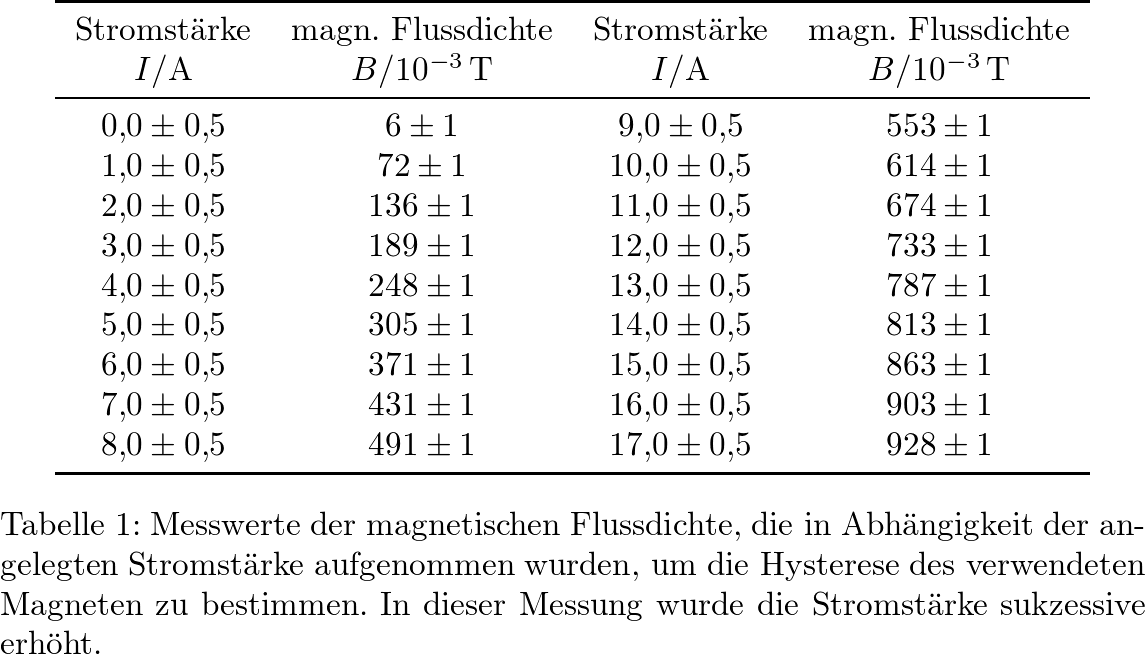

In [16]:
tab_hysteresis_inc = Table(siunitx=True, booktabs=True)
tab_hysteresis_inc.caption("""Messwerte der magnetischen Flussdichte, die in Abhängigkeit der angelegten Stromstärke
                        aufgenommen wurden, um die Hysterese des verwendeten Magneten zu bestimmen. 
                        In dieser Messung wurde die Stromstärke sukzessive erhöht.""")
tab_hysteresis_inc.label("hysterese_zunehmend")
tab_hysteresis_inc.addColumn(hysteresis_1["Strom I/A"].values[:9], title="Stromstärke", symbol="I", unit="\\ampere")
tab_hysteresis_inc.addColumn(hysteresis_1["Magnetfeld (I zunehmend) B/mT"].values[:9], title="magn. Flussdichte",
                         symbol="B", unit="\\milli\\tesla")
tab_hysteresis_inc.addColumn(hysteresis_1["Strom I/A"].values[9:], title="Stromstärke", symbol="I", unit="\\ampere")
tab_hysteresis_inc.addColumn(hysteresis_1["Magnetfeld (I zunehmend) B/mT"].values[9:], title="magn. Flussdichte",
                         symbol="B", unit="\\milli\\tesla")
Image(tab_hysteresis_inc.show(ipynb=True, quiet=False),width=700)

tab_hysteresis_inc.save(path_table + "Hysterese_zunehmend.tex")

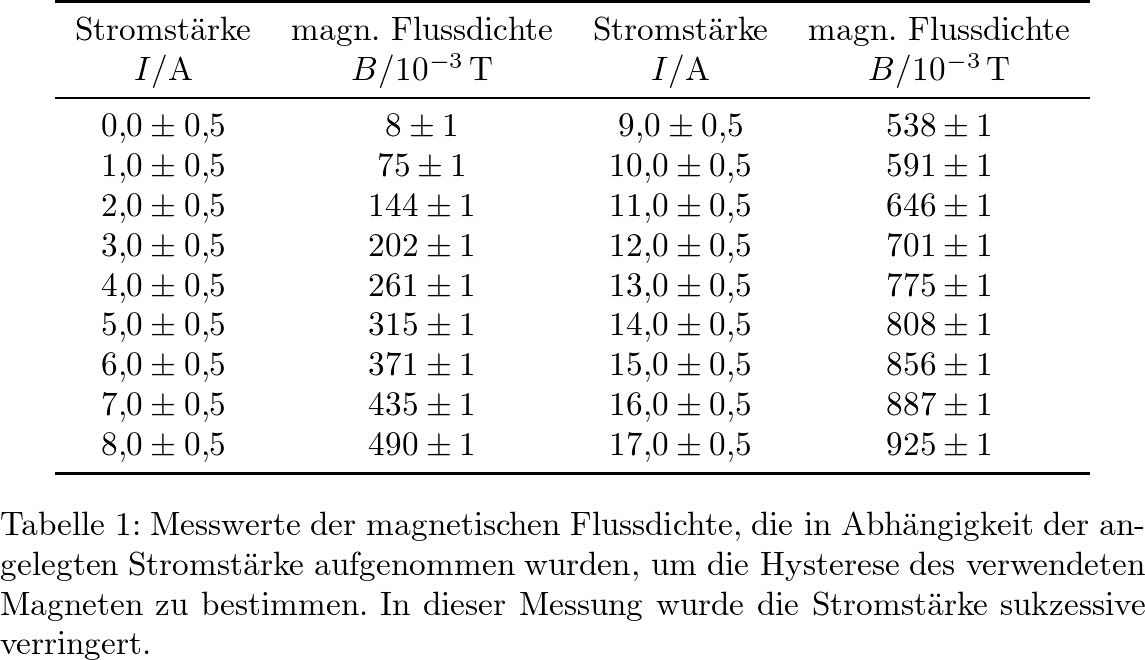

In [17]:
tab_hysteresis_dec = Table(siunitx=True, booktabs=True)
tab_hysteresis_dec.caption("""Messwerte der magnetischen Flussdichte, die in Abhängigkeit der angelegten Stromstärke
                        aufgenommen wurden, um die Hysterese des verwendeten Magneten zu bestimmen. 
                        In dieser Messung wurde die Stromstärke sukzessive verringert.""")
tab_hysteresis_dec.label("hysterese_zunehmend")
tab_hysteresis_dec.addColumn(hysteresis_1["Strom I/A"].values[:9], title="Stromstärke", symbol="I", unit="\\ampere")
tab_hysteresis_dec.addColumn(hysteresis_1["Magnetfeld (I abnehmend) B/mT"].values[:9], title="magn. Flussdichte",
                         symbol="B", unit="\\milli\\tesla")
tab_hysteresis_dec.addColumn(hysteresis_1["Strom I/A"].values[9:], title="Stromstärke", symbol="I", unit="\\ampere")
tab_hysteresis_dec.addColumn(hysteresis_1["Magnetfeld (I abnehmend) B/mT"].values[9:], title="magn. Flussdichte",
                         symbol="B", unit="\\milli\\tesla")
Image(tab_hysteresis_dec.show(ipynb=True, quiet=False),width=700)

tab_hysteresis_dec.save(path_table + "Hysterese_abnehmend.tex")

### Plots der Hysterese


#### Erste Messung

In [18]:
fit_parameter_hysteresis_1_decreasing = ucurve_fit(func_linear, hysteresis_1["Strom I/A"].values,
                                        hysteresis_1["Magnetfeld (I abnehmend) B/mT"].values)
print_errors(fit_parameter_hysteresis_1_decreasing, description=("a_ab =","b_ab ="))

fit_parameter_hysteresis_1_increasing = ucurve_fit(func_linear, hysteresis_1["Strom I/A"].values,
                                        hysteresis_1["Magnetfeld (I zunehmend) B/mT"].values)
print_errors(fit_parameter_hysteresis_1_increasing, description=("a_in =","b_in ="))

fit_current = np.linspace(0, 17, 1001)

a_ab =  54.60268320943114 +/- 0.8066786330934029
b_ab =  37.43274821608795 +/- 8.03310381999233
a_in =  56.16821466417253 +/- 1.030043435313515
b_in =  29.07017534402186 +/- 10.257426200589356


['linearer Fit\n $B(I) = (56 \\pm 1)\\frac{\\mathrm{mT}}{\\mathrm{A}}\\cdot I + (29 \\pm 10)\\mathrm{mT}$', 'Hysterese (I abnehmend)', 'Hysterese (I zunehmend)\n(50$\\sigma_{B}$ Fehlerbalken)']


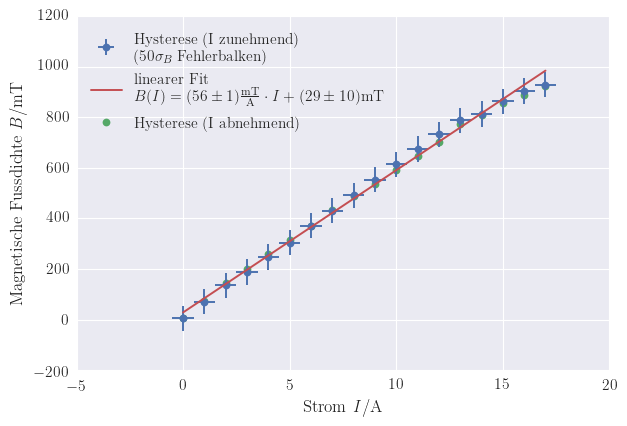

In [19]:
fig, ax_upper = plt.subplots()

ax_upper.set_ylim(-200, 1200.0)
ax_upper.set_xlabel(axis_label("Strom","I","A"))

#axis_scale(1e-3, ax=ax_upper, axis="y")
ax_upper.set_ylabel(axis_label("Magnetische Fussdichte","B","mT"))


errorbar(hysteresis_1["Strom I/A"],
         hysteresis_1["Magnetfeld (I zunehmend) B/mT"], factor_y = 50, color=colors[0],
         ax=ax_upper, label="Hysterese (I zunehmend)\n(50$\sigma_{B}$ Fehlerbalken)")
ax_upper.plot(fit_current, func_linear(fit_current, *noms(fit_parameter_hysteresis_1_increasing)),
              marker="", color=colors[2], 
              label="linearer Fit\n $B(I) = ({a_value:.2L}){a_unit:s}\\cdot I + ({b_value:.2L}){b_unit:s}$".format(
              a_value = fit_parameter_hysteresis_1_increasing[0],
              a_unit = r"\frac{\mathrm{mT}}{\mathrm{A}}",
              b_value = fit_parameter_hysteresis_1_increasing[1],
              b_unit = r"\mathrm{mT}"))

ax_upper.plot(noms(hysteresis_1["Strom I/A"]),
         noms(hysteresis_1["Magnetfeld (I abnehmend) B/mT"]),
         marker="o", linestyle="", color=colors[1], zorder=1,
         label="Hysterese (I abnehmend)")


handles, labels = ax_upper.get_legend_handles_labels()
print(labels)
# sort both labels and handles by labels
labels, handles = ([labels[i] for i in [2,0,1]], [handles[i] for i in [2,0,1]])  
ax_upper.legend(handles, labels, loc="best")#"lower right")
plt.tight_layout()
fig.savefig(path_graphics+"Hysterese_Messung_I_zunehmend.pdf")

['linearer Fit\n $B(I) = (55 \\pm 1)\\frac{\\mathrm{mT}}{\\mathrm{A}}\\cdot I + (37 \\pm 8)\\mathrm{mT}$', 'Hysterese (I zunehmend)', 'Hysterese (I abnehmend)\n(50$\\sigma_{B}$ Fehlerbalken)']


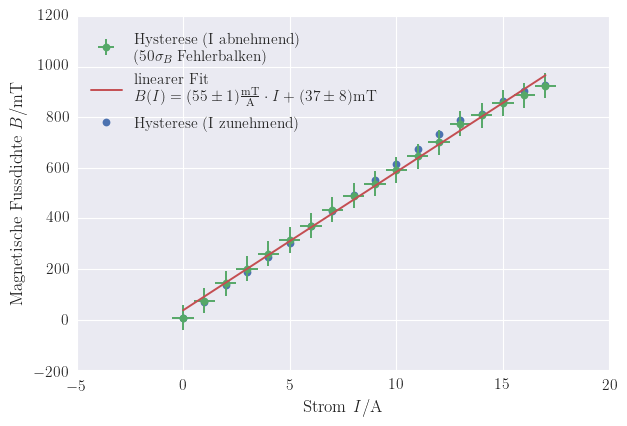

In [20]:
fig, ax_upper = plt.subplots()

ax_upper.set_ylim(-200, 1200.0)
ax_upper.set_xlabel(axis_label("Strom","I","A"))

#axis_scale(1e-3, ax=ax_upper, axis="y")
ax_upper.set_ylabel(axis_label("Magnetische Fussdichte","B","mT"))


errorbar(hysteresis_1["Strom I/A"],
         hysteresis_1["Magnetfeld (I abnehmend) B/mT"], factor_y = 50, color=colors[1],
         ax=ax_upper, label="Hysterese (I abnehmend)\n(50$\sigma_{B}$ Fehlerbalken)")

ax_upper.plot(fit_current, func_linear(fit_current, *noms(fit_parameter_hysteresis_1_decreasing)),
              marker="", color=colors[2], 
              label="linearer Fit\n $B(I) = ({a_value:.2L}){a_unit:s}\\cdot I + ({b_value:.2L}){b_unit:s}$".format(
              a_value = fit_parameter_hysteresis_1_decreasing[0],
              a_unit = r"\frac{\mathrm{mT}}{\mathrm{A}}",
              b_value = fit_parameter_hysteresis_1_decreasing[1],
              b_unit = r"\mathrm{mT}"))

ax_upper.plot(noms(hysteresis_1["Strom I/A"]),
         noms(hysteresis_1["Magnetfeld (I zunehmend) B/mT"]),
         marker="o", linestyle="", color=colors[0], zorder=1,
         label="Hysterese (I zunehmend)")


handles, labels = ax_upper.get_legend_handles_labels()
print(labels)
# sort both labels and handles by labels
labels, handles = ([labels[i] for i in [2,0,1]], [handles[i] for i in [2,0,1]])  
ax_upper.legend(handles, labels, loc="best")#"lower right")
plt.tight_layout()
fig.savefig(path_graphics+"Hysterese_Messung_I_abnehmend.pdf")

#### Zweite Messung

In [21]:
fit_parameter_hysteresis_2_decreasing = ucurve_fit(func_linear, hysteresis_2["Strom I/A"].values,
                                        hysteresis_2["Magnetfeld (I abnehmend) B/mT"].values)
print_errors(fit_parameter_hysteresis_2_decreasing, description=("a_ab =","b_ab ="))

fit_parameter_hysteresis_2_increasing = ucurve_fit(func_linear, hysteresis_2["Strom I/A"].values,
                                        hysteresis_2["Magnetfeld (I zunehmend) B/mT"].values)
print_errors(fit_parameter_hysteresis_2_increasing, description=("a_in =","b_in ="))

fit_current = np.linspace(0, 17, 1001)

a_ab =  61.465428276705666 +/- 0.904462746120188
b_ab =  27.543859649180828 +/- 9.006862405978026
a_in =  62.35190935209263 +/- 1.353267799050739
b_in =  38.17543670287929 +/- 13.47617383527143


['linearer Fit\n $B(I) = (62 \\pm 1)\\frac{\\mathrm{mT}}{\\mathrm{A}}\\cdot I + (38 \\pm 13)\\mathrm{mT}$', 'Hysterese (I abnehmend)', 'Hysterese (I zunehmend)\n(50$\\sigma_{B}$ Fehlerbalken)']


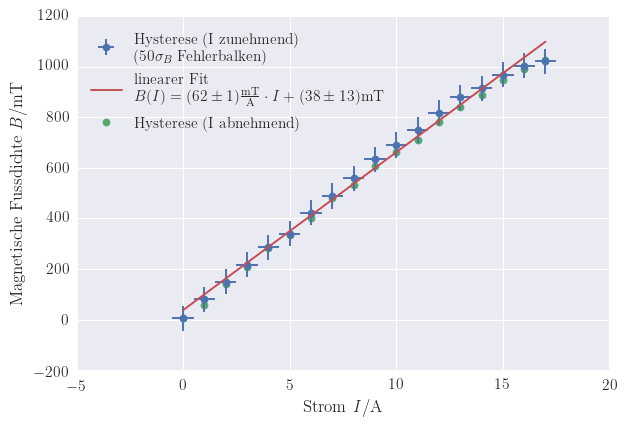

In [22]:
fig, ax_upper = plt.subplots()

#ax_upper.set_ylim(-200, 1200.0)
ax_upper.set_xlabel(axis_label("Strom","I","A"))

#axis_scale(1e-3, ax=ax_upper, axis="y")
ax_upper.set_ylabel(axis_label("Magnetische Fussdichte","B","mT"))


errorbar(hysteresis_2["Strom I/A"],
         hysteresis_2["Magnetfeld (I zunehmend) B/mT"], factor_y = 50, color=colors[0],
         ax=ax_upper, label="Hysterese (I zunehmend)\n(50$\sigma_{B}$ Fehlerbalken)")
ax_upper.plot(fit_current, func_linear(fit_current, *noms(fit_parameter_hysteresis_2_increasing)),
              marker="", color=colors[2], 
              label="linearer Fit\n $B(I) = ({a_value:.2L}){a_unit:s}\\cdot I + ({b_value:.2L}){b_unit:s}$".format(
              a_value = fit_parameter_hysteresis_2_increasing[0],
              a_unit = r"\frac{\mathrm{mT}}{\mathrm{A}}",
              b_value = fit_parameter_hysteresis_2_increasing[1],
              b_unit = r"\mathrm{mT}"))

ax_upper.plot(noms(hysteresis_2["Strom I/A"]),
         noms(hysteresis_2["Magnetfeld (I abnehmend) B/mT"]),
         marker="o", linestyle="", color=colors[1], zorder=1,
         label="Hysterese (I abnehmend)")



handles, labels = ax_upper.get_legend_handles_labels()
print(labels)
# sort both labels and handles by labels
labels, handles = ([labels[i] for i in [2,0,1]], [handles[i] for i in [2,0,1]])  
ax_upper.legend(handles, labels, loc="upper left")#"lower right")
plt.tight_layout()
fig.savefig(path_graphics+"Hysterese_Messung_II_zunehmend.pdf")

['linearer Fit\n $B(I) = (61 \\pm 1)\\frac{\\mathrm{mT}}{\\mathrm{A}}\\cdot I + (28 \\pm 9)\\mathrm{mT}$', 'Hysterese (I zunehmend)', 'Hysterese (I abnehmend)\n(50$\\sigma_{B}$ Fehlerbalken)']


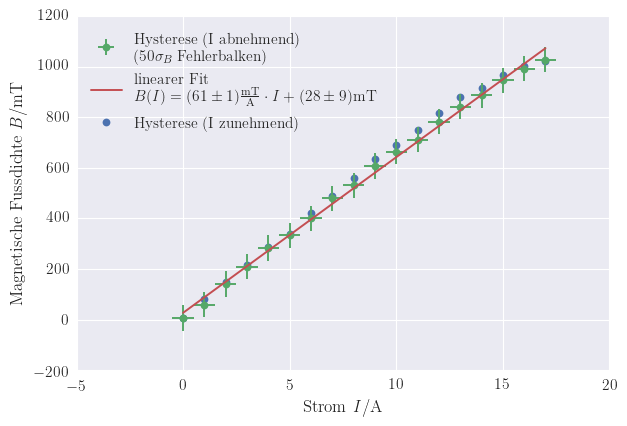

In [23]:
fig, ax_upper = plt.subplots()

#ax_upper.set_ylim(-200, 1200.0)
ax_upper.set_xlabel(axis_label("Strom","I","A"))

#axis_scale(1e-3, ax=ax_upper, axis="y")
ax_upper.set_ylabel(axis_label("Magnetische Fussdichte","B","mT"))


errorbar(hysteresis_2["Strom I/A"],
         hysteresis_2["Magnetfeld (I abnehmend) B/mT"], factor_y = 50, color=colors[1],
         ax=ax_upper, label="Hysterese (I abnehmend)\n(50$\sigma_{B}$ Fehlerbalken)")

ax_upper.plot(fit_current, func_linear(fit_current, *noms(fit_parameter_hysteresis_2_decreasing)),
              marker="", color=colors[2], 
              label="linearer Fit\n $B(I) = ({a_value:.2L}){a_unit:s}\\cdot I + ({b_value:.2L}){b_unit:s}$".format(
              a_value = fit_parameter_hysteresis_2_decreasing[0],
              a_unit = r"\frac{\mathrm{mT}}{\mathrm{A}}",
              b_value = fit_parameter_hysteresis_2_decreasing[1],
              b_unit = r"\mathrm{mT}"))

ax_upper.plot(noms(hysteresis_2["Strom I/A"]),
         noms(hysteresis_2["Magnetfeld (I zunehmend) B/mT"]),
         marker="o", linestyle="", color=colors[0], zorder=1,
         label="Hysterese (I zunehmend)")


handles, labels = ax_upper.get_legend_handles_labels()
print(labels)
# sort both labels and handles by labels
labels, handles = ([labels[i] for i in [2,0,1]], [handles[i] for i in [2,0,1]])  
ax_upper.legend(handles, labels, loc="best")#"lower right")
plt.tight_layout()
fig.savefig(path_graphics+"Hysterese_Messung_II_abnehmend.pdf")

In [24]:
def calculate_magneticfield(current, fit_slope, fit_intercept):
    return fit_slope * current + fit_intercept     

## Laden Stromstärken

In [25]:
magneticfield_current = pd.read_csv(path_data+"Stromstaerken.csv")

In [26]:
magneticfield_current.head()

,Strom I/A
0,0
1,5
2,10
3,17


In [27]:
magneticfield_current["Strom I/A"] = unp.uarray(magneticfield_current["Strom I/A"], uncertainties["Strom I/A"]) 

In [28]:
magneticfield_current["Magnetfeld I B/mT"] = calculate_magneticfield(magneticfield_current["Strom I/A"].values,
                                                                    *fit_parameter_hysteresis_1_increasing)
magneticfield_current["Magnetfeld II B/mT"] = calculate_magneticfield(magneticfield_current["Strom I/A"].values,
                                                                    *fit_parameter_hysteresis_2_increasing)
magneticfield_current.head()


,Strom I/A,Magnetfeld I B/mT,Magnetfeld II B/mT
0,0.0+/-0.5,29+/-30,38+/-34
1,5.0+/-0.5,310+/-29,350+/-32
2,10.0+/-0.5,591+/-29,662+/-32
3,17.0+/-0.5,984+/-30,1098+/-34


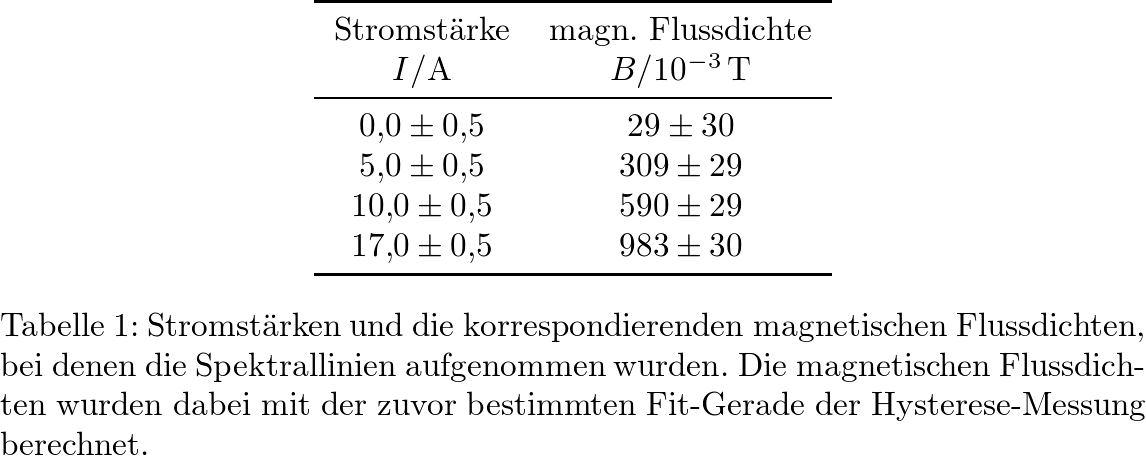

In [29]:
tab_current = Table(siunitx=True, booktabs=True)
tab_current.caption("""Stromstärken und die korrespondierenden magnetischen Flussdichten,
                    bei denen die Spektrallinien aufgenommen wurden. 
                    Die magnetischen Flussdichten wurden dabei mit der zuvor bestimmten Fit-Gerade der
                    Hysterese-Messung berechnet.""")
tab_current.label("strom_magnetfeld")
tab_current.addColumn(magneticfield_current["Strom I/A"].values, title="Stromstärke", symbol="I", unit="\\ampere")
tab_current.addColumn(magneticfield_current["Magnetfeld I B/mT"], title="magn. Flussdichte",
                         symbol="B", unit="\\milli\\tesla")
#tab_current.addColumn(["rot, blau", "rot $\\sigma$", "blau $\\sigma$", "blau $\\pi$"], title="Messung")
Image(tab_current.show(ipynb=True, quiet=False),width=700)

tab_current.save(path_table + "Magnetfeld_Aufnahmen.tex")

## Analyse der Spekrallinien

In [30]:
def wavelength_shift(Delta_s, delta_s, dispersion_area):
    return 0.5 * delta_s / Delta_s * dispersion_area

def energy_shift(wavelength, wavelength_shift):
    return (const.h * const.c / wavelength**2) * wavelength_shift

In [31]:
wavelength_red = 643.8e-9
wavelength_blue = 480.0e-9

dispersion_area_red = 4.89e-11 
dispersion_area_blue = 2.70e-11

### Rote Linie: $\sigma$-Übergang

#### Laden der Messwerte

In [32]:
lineshift_red_sigma = pd.read_csv(path_data+"Abstaende_rot_sigma.csv")
lineshift_red_sigma.head()

,Abstand Δs/px,Abstand δs/px
0,399,195
1,360,186
2,337,168
3,321,165
4,299,150


In [33]:
# Erzeugung fehlerbehafteter Messwerte
lineshift_red_sigma["Abstand Δs/px"] = unp.uarray(lineshift_red_sigma["Abstand Δs/px"].values,
                                                  uncertainties["Abstand s/px"]) 
lineshift_red_sigma["Abstand δs/px"] = unp.uarray(lineshift_red_sigma["Abstand δs/px"].values,
                                                  uncertainties["Abstand s/px"]) 

In [34]:
lineshift_red_sigma.head()

,Abstand Δs/px,Abstand δs/px
0,399+/-5,195+/-5
1,360+/-5,186+/-5
2,337+/-5,168+/-5
3,321+/-5,165+/-5
4,299+/-5,150+/-5


In [35]:
# Verhältnis der Abstände
lineshift_red_sigma["Verhaeltnis δs/Δs"] = (lineshift_red_sigma["Abstand δs/px"].values /
                                            lineshift_red_sigma['Abstand Δs/px'].values)
lineshift_red_sigma.head()

,Abstand Δs/px,Abstand δs/px,Verhaeltnis δs/Δs
0,399+/-5,195+/-5,0.489+/-0.014
1,360+/-5,186+/-5,0.517+/-0.016
2,337+/-5,168+/-5,0.499+/-0.017
3,321+/-5,165+/-5,0.514+/-0.018
4,299+/-5,150+/-5,0.502+/-0.019


In [36]:
lineshift_red_sigma["Wellenlaengenverschiebung δλ/m"] = wavelength_shift(lineshift_red_sigma["Abstand Δs/px"].values,
                                                                        lineshift_red_sigma["Abstand δs/px"].values,
                                                                        dispersion_area_red)
lineshift_red_sigma.head()

,Abstand Δs/px,Abstand δs/px,Verhaeltnis δs/Δs,Wellenlaengenverschiebung δλ/m
0,399+/-5,195+/-5,0.489+/-0.014,(1.195+/-0.034)e-11
1,360+/-5,186+/-5,0.517+/-0.016,(1.26+/-0.04)e-11
2,337+/-5,168+/-5,0.499+/-0.017,(1.22+/-0.04)e-11
3,321+/-5,165+/-5,0.514+/-0.018,(1.26+/-0.04)e-11
4,299+/-5,150+/-5,0.502+/-0.019,(1.23+/-0.05)e-11


In [37]:
mean_lineshift_red = umean(lineshift_red_sigma["Wellenlaengenverschiebung δλ/m"].values)
print("Mittlere Wellenlängenverschiebung: {0:.1u} m".format(mean_lineshift_red))

energyshift_red = energy_shift(wavelength_red, mean_lineshift_red)
print("Energieverschiebung: {0:.1u} J".format(energyshift_red))

Mittlere Wellenlängenverschiebung: (1.23+/-0.01)e-11 m
Energieverschiebung: (5.91+/-0.07)e-24 J


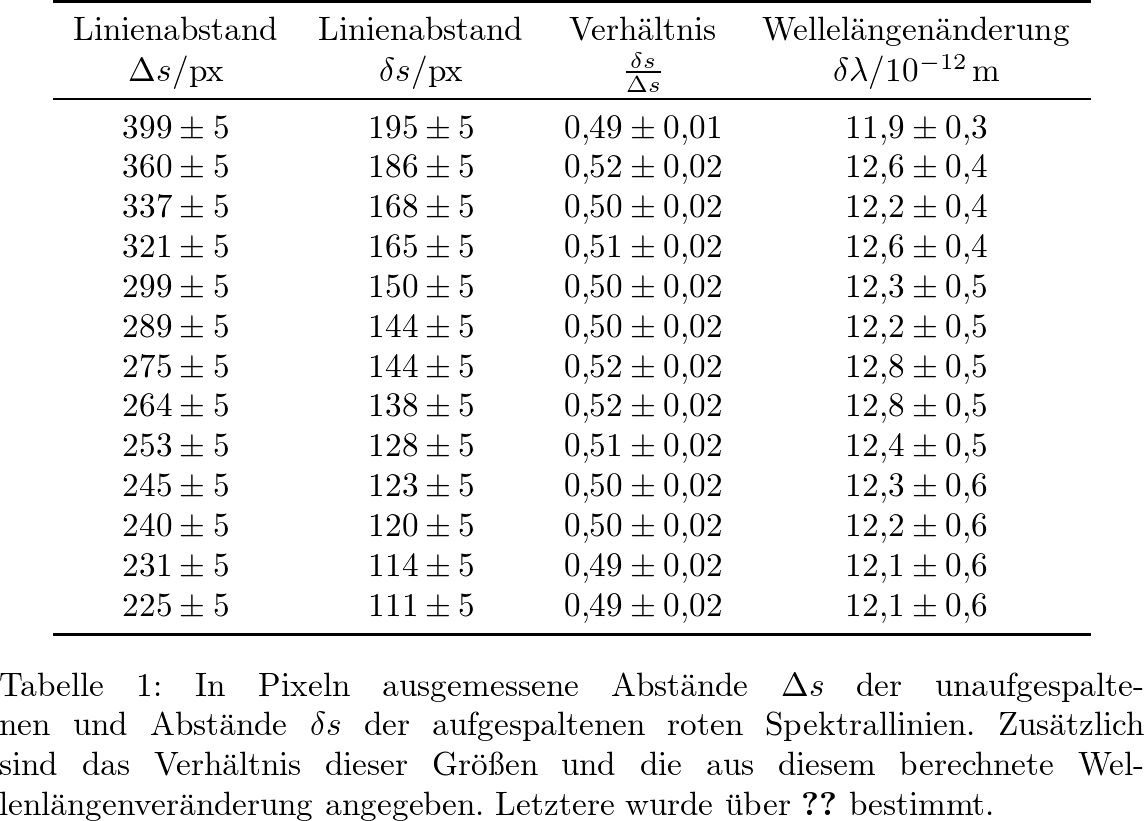

In [38]:
tab_lineshift_red_sigma = Table(siunitx=True, booktabs=True)
tab_lineshift_red_sigma.caption("""In Pixeln ausgemessene Abstände $\Delta s$ der unaufgespaltenen  
                                und Abstände $\delta s$ der aufgespaltenen roten Spektrallinien. Zusätzlich sind das
                                Verhältnis dieser Größen und die aus diesem berechnete 
                                Wellenlängenveränderung angegeben. Letztere wurde über \\ref{eq:} bestimmt.""")
tab_lineshift_red_sigma.label("linienverschiebung")
tab_lineshift_red_sigma.addColumn(lineshift_red_sigma["Abstand Δs/px"].values[:], 
                                  title="Linienabstand", symbol="\Delta s", unit="px")
tab_lineshift_red_sigma.addColumn(lineshift_red_sigma["Abstand δs/px"].values[:], 
                                  title="Linienabstand", symbol="\delta s", unit="px")
tab_lineshift_red_sigma.addColumn(lineshift_red_sigma["Verhaeltnis δs/Δs"].values[:], 
                                  title="Verhältnis", symbol="\\frac{\delta s}{\Delta s}")
tab_lineshift_red_sigma.addColumn(lineshift_red_sigma["Wellenlaengenverschiebung δλ/m"].values[:]*1e12, 
                                  title="Wellelängenänderung", symbol="\delta \lambda", unit="\\pico\\meter")
Image(tab_lineshift_red_sigma.show(ipynb=True, quiet=False),width=700)

tab_lineshift_red_sigma.save(path_table + "Linienverschiebung_rot_sigma.tex")

### Blaue Linie: $\sigma$-Übergang

#### Laden der Messwerte

In [39]:
lineshift_blue_sigma = pd.read_csv(path_data+"Abstaende_blau_sigma.csv")
lineshift_blue_sigma.head()

,Abstand Δs/px,Abstand δs/px
0,392,213
1,340,186
2,324,168
3,292,153
4,280,138


In [40]:
# Erzeugung fehlerbehafteter Messwerte
lineshift_blue_sigma["Abstand Δs/px"] = unp.uarray(lineshift_blue_sigma["Abstand Δs/px"].values,
                                                  uncertainties["Abstand s/px"]) 
lineshift_blue_sigma["Abstand δs/px"] = unp.uarray(lineshift_blue_sigma["Abstand δs/px"].values,
                                                  uncertainties["Abstand s/px"]) 

In [41]:
lineshift_blue_sigma.head()

,Abstand Δs/px,Abstand δs/px
0,392+/-5,213+/-5
1,340+/-5,186+/-5
2,324+/-5,168+/-5
3,292+/-5,153+/-5
4,280+/-5,138+/-5


In [42]:
# Verhältnis der Abstände
lineshift_blue_sigma["Verhaeltnis δs/Δs"] = (lineshift_blue_sigma["Abstand δs/px"].values /
                                            lineshift_blue_sigma['Abstand Δs/px'].values)
lineshift_blue_sigma.head()

,Abstand Δs/px,Abstand δs/px,Verhaeltnis δs/Δs
0,392+/-5,213+/-5,0.543+/-0.015
1,340+/-5,186+/-5,0.547+/-0.017
2,324+/-5,168+/-5,0.519+/-0.017
3,292+/-5,153+/-5,0.524+/-0.019
4,280+/-5,138+/-5,0.493+/-0.020


In [43]:
lineshift_blue_sigma["Wellenlaengenverschiebung δλ/m"] = wavelength_shift(lineshift_blue_sigma["Abstand Δs/px"].values,
                                                                        lineshift_blue_sigma["Abstand δs/px"].values,
                                                                        dispersion_area_blue)
lineshift_blue_sigma.head()

,Abstand Δs/px,Abstand δs/px,Verhaeltnis δs/Δs,Wellenlaengenverschiebung δλ/m
0,392+/-5,213+/-5,0.543+/-0.015,(7.34+/-0.20)e-12
1,340+/-5,186+/-5,0.547+/-0.017,(7.39+/-0.23)e-12
2,324+/-5,168+/-5,0.519+/-0.017,(7.00+/-0.23)e-12
3,292+/-5,153+/-5,0.524+/-0.019,(7.07+/-0.26)e-12
4,280+/-5,138+/-5,0.493+/-0.020,(6.65+/-0.27)e-12


In [44]:
mean_lineshift_blue_sigma = umean(lineshift_blue_sigma["Wellenlaengenverschiebung δλ/m"].values)
print("Mittlere Wellenlängenverschiebung: {0:.1u} m".format(mean_lineshift_blue_sigma))

energyshift_blue_sigma = energy_shift(wavelength_blue, mean_lineshift_blue_sigma)
print("Energieverschiebung: {0:.1u} J".format(energyshift_blue_sigma))

Mittlere Wellenlängenverschiebung: (6.81+/-0.08)e-12 m
Energieverschiebung: (5.87+/-0.07)e-24 J


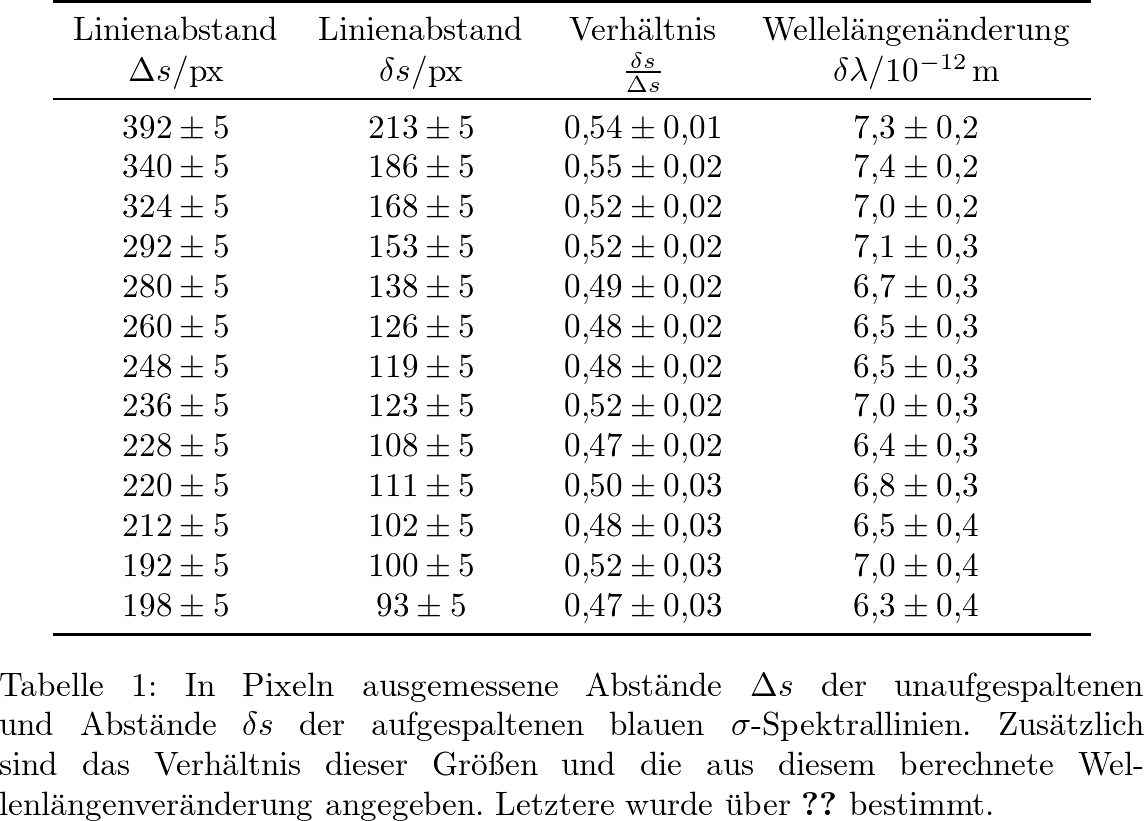

In [45]:
tab_lineshift_blue_sigma = Table(siunitx=True, booktabs=True)
tab_lineshift_blue_sigma.caption("""In Pixeln ausgemessene Abstände $\Delta s$ der unaufgespaltenen  
                                und Abstände $\delta s$ der aufgespaltenen blauen $\\sigma$-Spektrallinien.
                                Zusätzlich sind das Verhältnis dieser Größen und die aus diesem berechnete 
                                Wellenlängenveränderung angegeben. Letztere wurde über \\ref{eq:} bestimmt.""")
tab_lineshift_blue_sigma.label("linienverschiebung")
tab_lineshift_blue_sigma.addColumn(lineshift_blue_sigma["Abstand Δs/px"].values[:], 
                                  title="Linienabstand", symbol="\Delta s", unit="px")
tab_lineshift_blue_sigma.addColumn(lineshift_blue_sigma["Abstand δs/px"].values[:], 
                                  title="Linienabstand", symbol="\delta s", unit="px")
tab_lineshift_blue_sigma.addColumn(lineshift_blue_sigma["Verhaeltnis δs/Δs"].values[:], 
                                  title="Verhältnis", symbol="\\frac{\delta s}{\Delta s}")
tab_lineshift_blue_sigma.addColumn(lineshift_blue_sigma["Wellenlaengenverschiebung δλ/m"].values[:]*1e12, 
                                  title="Wellelängenänderung", symbol="\delta \lambda", unit="\\pico\\meter")
Image(tab_lineshift_blue_sigma.show(ipynb=True, quiet=False),width=700)

tab_lineshift_blue_sigma.save(path_table + "Linienverschiebung_blau_sigma.tex")

### Blaue Linie: $\pi$-Übergang

#### Laden der Messwerte

In [46]:
lineshift_blue_pi = pd.read_csv(path_data+"Abstaende_blau_pi.csv")
lineshift_blue_pi.head()

,Abstand Δs/px,Abstand δs/px
0,387,192
1,351,150
2,315,135
3,297,123
4,285,120


In [47]:
# Erzeugung fehlerbehafteter Messwerte
lineshift_blue_pi["Abstand Δs/px"] = unp.uarray(lineshift_blue_pi["Abstand Δs/px"].values,
                                                  uncertainties["Abstand s/px"]) 
lineshift_blue_pi["Abstand δs/px"] = unp.uarray(lineshift_blue_pi["Abstand δs/px"].values,
                                                  uncertainties["Abstand s/px"]) 

In [48]:
lineshift_blue_pi.head()

,Abstand Δs/px,Abstand δs/px
0,387+/-5,192+/-5
1,351+/-5,150+/-5
2,315+/-5,135+/-5
3,297+/-5,123+/-5
4,285+/-5,120+/-5


In [49]:
# Verhältnis der Abstände
lineshift_blue_pi["Verhaeltnis δs/Δs"] = (lineshift_blue_pi["Abstand δs/px"].values /
                                            lineshift_blue_pi['Abstand Δs/px'].values)
lineshift_blue_pi.head()

,Abstand Δs/px,Abstand δs/px,Verhaeltnis δs/Δs
0,387+/-5,192+/-5,0.496+/-0.014
1,351+/-5,150+/-5,0.427+/-0.015
2,315+/-5,135+/-5,0.429+/-0.017
3,297+/-5,123+/-5,0.414+/-0.018
4,285+/-5,120+/-5,0.421+/-0.019


In [50]:
lineshift_blue_pi["Wellenlaengenverschiebung δλ/m"] = wavelength_shift(lineshift_blue_pi["Abstand Δs/px"].values,
                                                                        lineshift_blue_pi["Abstand δs/px"].values,
                                                                        dispersion_area_blue)
lineshift_blue_pi.head()

,Abstand Δs/px,Abstand δs/px,Verhaeltnis δs/Δs,Wellenlaengenverschiebung δλ/m
0,387+/-5,192+/-5,0.496+/-0.014,(6.70+/-0.19)e-12
1,351+/-5,150+/-5,0.427+/-0.015,(5.77+/-0.21)e-12
2,315+/-5,135+/-5,0.429+/-0.017,(5.79+/-0.23)e-12
3,297+/-5,123+/-5,0.414+/-0.018,(5.59+/-0.25)e-12
4,285+/-5,120+/-5,0.421+/-0.019,(5.68+/-0.26)e-12


In [51]:
mean_lineshift_blue_pi = umean(lineshift_blue_pi["Wellenlaengenverschiebung δλ/m"].values)
print("Mittlere Wellenlängenverschiebung: {0:.1u} m".format(mean_lineshift_blue_pi))

energyshift_blue_pi = energy_shift(wavelength_blue, mean_lineshift_blue_pi)
print("Energieverschiebung: {0:.1u} J".format(energyshift_blue_pi))

Mittlere Wellenlängenverschiebung: (5.83+/-0.08)e-12 m
Energieverschiebung: (5.02+/-0.07)e-24 J


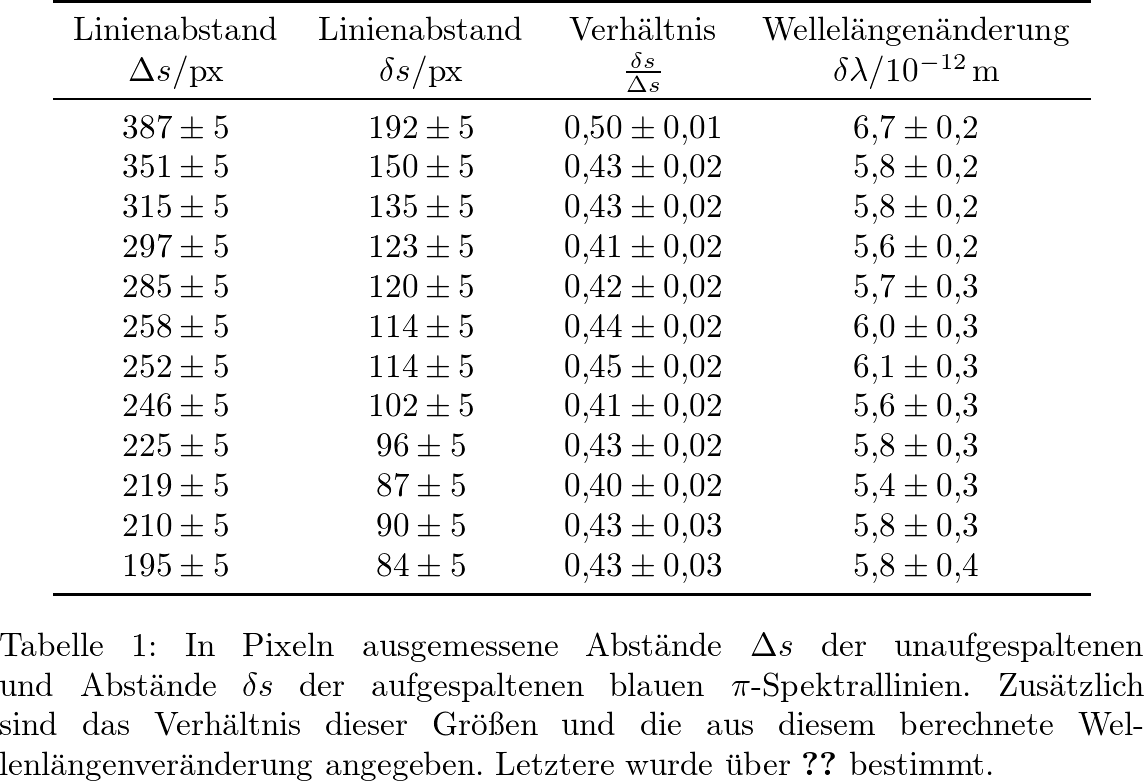

In [52]:
tab_lineshift_blue_pi = Table(siunitx=True, booktabs=True)
tab_lineshift_blue_pi.caption("""In Pixeln ausgemessene Abstände $\Delta s$ der unaufgespaltenen  
                                und Abstände $\delta s$ der aufgespaltenen blauen $\\pi$-Spektrallinien.
                                Zusätzlich sind das Verhältnis dieser Größen und die aus diesem berechnete 
                                Wellenlängenveränderung angegeben. Letztere wurde über \\ref{eq:} bestimmt.""")
tab_lineshift_blue_pi.label("linienverschiebung")
tab_lineshift_blue_pi.addColumn(lineshift_blue_pi["Abstand Δs/px"].values[:], 
                                  title="Linienabstand", symbol="\Delta s", unit="px")
tab_lineshift_blue_pi.addColumn(lineshift_blue_pi["Abstand δs/px"].values[:], 
                                  title="Linienabstand", symbol="\delta s", unit="px")
tab_lineshift_blue_pi.addColumn(lineshift_blue_pi["Verhaeltnis δs/Δs"].values[:], 
                                  title="Verhältnis", symbol="\\frac{\delta s}{\Delta s}")
tab_lineshift_blue_pi.addColumn(lineshift_blue_pi["Wellenlaengenverschiebung δλ/m"].values[:]*1e12, 
                                  title="Wellelängenänderung", symbol="\delta \lambda", unit="\\pico\\meter")
Image(tab_lineshift_blue_pi.show(ipynb=True, quiet=False),width=700)

tab_lineshift_blue_pi.save(path_table + "Linienverschiebung_blau_pi.tex")

#### Berechnung der Lande-Faktoren $g_{i,j}$

In [53]:
lande_factor_red_theoretical = 1
lande_factor_blue_sigma_theoretical = 2
lande_factor_blue_pi_theoretical = 0.5

In [62]:
lande_factor_red_sigma = energyshift_red/(magneticfield_current["Magnetfeld I B/mT"][2]*1e-3*
                                          sp.constants.physical_constants["Bohr magneton"][0])
relativ_diffrence_red_sigma = abs(lande_factor_red_sigma - lande_factor_red_theoretical)/lande_factor_red_theoretical
print("Lande-Faktor: {0:.1u}".format(lande_factor_red_sigma))
print("relative Abweichung: {0:.1u}".format(relativ_diffrence_red_sigma))

Lande-Faktor: 1.08+/-0.05
relative Abweichung: 0.08+/-0.05


In [61]:
lande_factor_blue_sigma = energyshift_blue_sigma/(magneticfield_current["Magnetfeld I B/mT"][1]*1e-3*
                                          sp.constants.physical_constants["Bohr magneton"][0])
relativ_diffrence_blue_sigma = (abs(lande_factor_blue_sigma - lande_factor_blue_sigma_theoretical)/lande_factor_blue_sigma_theoretical)
print("Lande-Faktor, blau, sigma: {0:.1u}".format(lande_factor_blue_sigma))
print("relative Abweichung: {0:.3u}".format(relativ_diffrence_blue_sigma))

Lande-Faktor, blau, sigma: 2.0+/-0.2
relative Abweichung: 0.0220+/-0.0959


In [59]:
lande_factor_blue_pi = energyshift_blue_pi/(magneticfield_current["Magnetfeld I B/mT"][3]*1e-3*
                                          sp.constants.physical_constants["Bohr magneton"][0])
relativ_diffrence_blue_pi = abs(lande_factor_blue_pi - lande_factor_blue_pi_theoretical)/lande_factor_blue_pi_theoretical
print("Lande-Faktor, blau, pi: {0:.1u}".format(lande_factor_blue_pi))
print("relative Abweichung: {0:.1u}".format(relativ_diffrence_blue_pi))

Lande-Faktor, blau, pi: 0.55+/-0.02
relative Abweichung: 0.10+/-0.04


In [57]:
sp.constants.physical_constants["Bohr magneton"]

(9.274009994e-24, 'J T^-1', 5.7e-32)

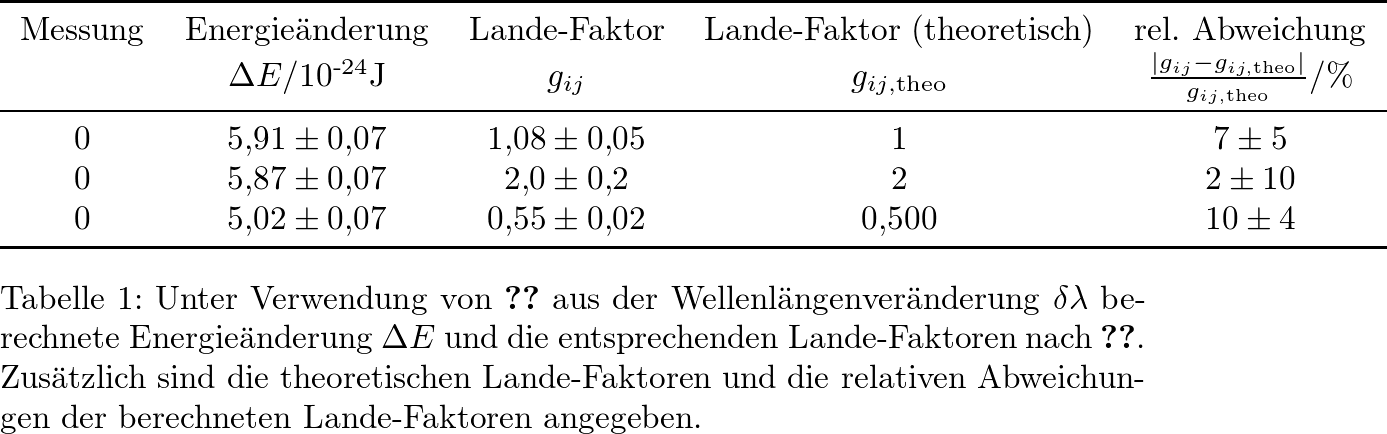

In [80]:
tab_lande_factors = Table(siunitx=True, booktabs=True)
tab_lande_factors.caption("""Unter Verwendung von \\ref{} aus der Wellenlängenveränderung $\\delta \\lambda$
                          berechnete Energieänderung $\\Delta E$ und die entsprechenden Lande-Faktoren nach \\ref{}.
                          Zusätzlich sind die theoretischen Lande-Faktoren und die relativen Abweichungen
                          der berechneten Lande-Faktoren angegeben.""")
tab_lande_factors.label("lande_ergebnis")
tab_lande_factors.addColumn([0,0,0], title="Messung", symbol="")
tab_lande_factors.addColumn(np.array([energyshift_red, energyshift_blue_sigma, energyshift_blue_pi])*1e24,
                            title="Energieänderung",symbol="\Delta E", unit="10\\tothe{-24}\\joule")
tab_lande_factors.addColumn([lande_factor_red_sigma, lande_factor_blue_sigma, lande_factor_blue_pi],
                            title="Lande-Faktor",symbol="g_{ij}")
tab_lande_factors.addColumn([lande_factor_red_theoretical, lande_factor_blue_sigma_theoretical, lande_factor_blue_pi_theoretical],
                            title="Lande-Faktor (theoretisch)",symbol="g_{ij,\mathrm{theo}}")
tab_lande_factors.addColumn(np.array([relativ_diffrence_red_sigma,
                                      relativ_diffrence_blue_sigma,
                                      relativ_diffrence_blue_pi])*100,
                            title="rel. Abweichung",
                            symbol="\\frac{|g_{ij} - g_{ij,\mathrm{theo}}|}{g_{ij,\mathrm{theo}}}", unit="\\percent")

Image(tab_lande_factors.show(ipynb=True), width=900)

tab_lande_factors.save(path_table+"Lande_Faktoren_Ergebnis.tex")